# Model Development & Evaluation

@author - Anuj Patel

This notebook covers:
1. Loading and preprocessing the feature dataset
2. Training multiple machine learning models
3. Hyperparameter tuning and cross-validation
4. Model evaluation and performance comparison
5. Feature importance analysis
6. Model persistence for trading deployment

## 1. Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
import joblib
from pathlib import Path
import datetime

warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"Current time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Current time: 2025-07-12 10:27:02


## 2. Load and Explore the Feature Dataset

In [47]:
# Load the feature dataset
df = pd.read_csv('../data/final_feature_dataset.csv')

df['target_significant'] = (df['target_1d'] > 0.01).astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique stocks: {sorted(df['ticker'].unique())}")

# Display basic info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Dataset shape: (7490, 39)
Date range: 2022-01-05 to 2024-12-27
Unique stocks: ['AAPL', 'ADBE', 'AMZN', 'CRM', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA', 'TSLA']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7490 entries, 0 to 7489
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Open                    7490 non-null   float64
 1   High                    7490 non-null   float64
 2   Low                     7490 non-null   float64
 3   Close                   7490 non-null   float64
 4   Volume                  7490 non-null   int64  
 5   Dividends               7490 non-null   float64
 6   Stock Splits            7490 non-null   float64
 7   Returns                 7490 non-null   float64
 8   Volume_MA_20            7320 non-null   float64
 9   Price_MA_5              7470 non-null   float64
 10  Price_MA_20             7320 non-null   float64
 11  Volatility_20           7

Target 1-day binary distribution:
target_1d_binary
1    0.517623
0    0.482377
Name: proportion, dtype: float64

Target 1-day returns statistics:
count    7490.000000
mean        0.000957
std         0.027110
min        -0.351166
25%        -0.012304
50%         0.000857
75%         0.014061
max         0.243696
Name: target_1d, dtype: float64


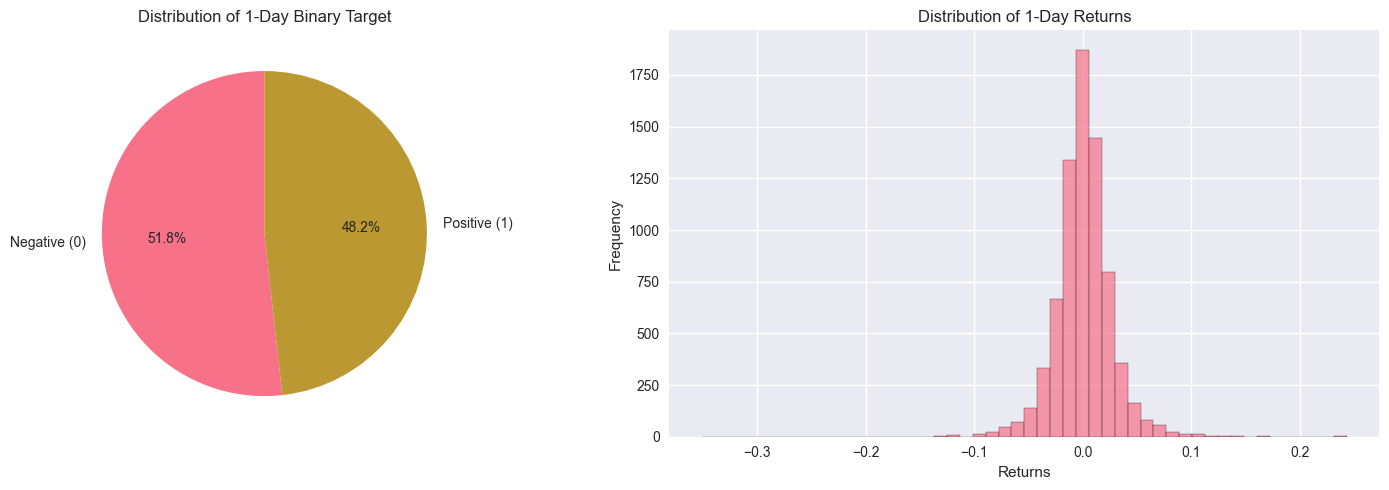

In [48]:
# Explore target variables
print(f"Target 1-day binary distribution:")
print(df['target_1d_binary'].value_counts(normalize=True))

print(f"\nTarget 1-day returns statistics:")
print(df['target_1d'].describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Binary target distribution
axes[0].pie(df['target_1d_binary'].value_counts(), 
           labels=['Negative (0)', 'Positive (1)'], 
           autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of 1-Day Binary Target')

# Returns distribution
axes[1].hist(df['target_1d'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of 1-Day Returns')
axes[1].set_xlabel('Returns')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [49]:
# Convert date to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# Define feature columns (exclude targets and metadata)
exclude_cols = ['date', 'ticker', 'target_1d', 'target_5d', 'target_1d_binary', 
                'returns_1d', 'returns_5d', 'target_significant', 'target_top_quartile', 
                'target_vs_market', 'target_vol_adj', 'market_return', 'volatility_5d']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Handle missing values
print(f"\nHandling missing values...")
print(f"Missing values before: {df[feature_cols].isnull().sum().sum()}")

# Forward fill for time series data, then drop remaining NaN
df[feature_cols] = df[feature_cols].fillna(method='ffill')
df = df.dropna(subset=feature_cols + ['target_1d_binary'])

print(f"Missing values after: {df[feature_cols].isnull().sum().sum()}")
print(f"Final dataset shape: {df.shape}")

Feature columns (30):
 1. Open
 2. High
 3. Low
 4. Close
 5. Volume
 6. Dividends
 7. Stock Splits
 8. Returns
 9. Volume_MA_20
10. Price_MA_5
11. Price_MA_20
12. Volatility_20
13. RSI
14. sentiment_mean
15. sentiment_std
16. news_count
17. sentiment_pos_mean
18. sentiment_pos_max
19. sentiment_neg_mean
20. sentiment_neg_max
21. sentiment_neutral_mean
22. volume_ratio
23. sentiment_1d_lag
24. sentiment_3d_avg
25. sentiment_5d_avg
26. news_count_3d
27. price_above_ma20
28. price_above_ma5
29. rsi_overbought
30. rsi_oversold

Handling missing values...
Missing values before: 870
Missing values after: 0
Final dataset shape: (7472, 39)


In [50]:
# Prepare features and target
X = df[feature_cols].copy()
y = df['target_significant'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Binary target shape: {y.shape}")

# Check for infinite values
inf_mask = np.isinf(X.select_dtypes(include=[np.number]))
if inf_mask.any().any():
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

# Scale features for models that need it
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

Feature matrix shape: (7472, 30)
Binary target shape: (7472,)


## 4. Time Series Split for Validation

In [51]:
# Create time series split for proper validation
tscv = TimeSeriesSplit(n_splits=5)

# Split data chronologically
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print(f"Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nDate ranges:")
print(f"Train: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Val: {val_df['date'].min()} to {val_df['date'].max()}")
print(f"Test: {test_df['date'].min()} to {test_df['date'].max()}")

# Prepare split datasets
X_train = X_scaled.iloc[:train_size]
X_val = X_scaled.iloc[train_size:train_size + val_size]
X_test = X_scaled.iloc[train_size + val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size + val_size]
y_test = y.iloc[train_size + val_size:]

Training set: 5230 samples (70.0%)
Validation set: 1120 samples (15.0%)
Test set: 1122 samples (15.0%)

Date ranges:
Train: 2022-01-05 00:00:00 to 2024-12-27 00:00:00
Val: 2022-01-05 00:00:00 to 2024-12-27 00:00:00
Test: 2022-01-05 00:00:00 to 2024-12-27 00:00:00


## 5. Model Training

In [52]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

# Train models and store results
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = (y_pred == y_val).mean()
    auc = roc_auc_score(y_val, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

print("\nAll models trained successfully")


Training Logistic Regression
Logistic Regression - Accuracy: 0.6464, AUC: 0.4854

Training Random Forest
Random Forest - Accuracy: 0.5759, AUC: 0.5395

Training Gradient Boosting
Gradient Boosting - Accuracy: 0.5750, AUC: 0.5428

Training XGBoost
XGBoost - Accuracy: 0.5893, AUC: 0.5293

All models trained successfully


## 6. Model Evaluation and Comparison

Model Performance Comparison (Validation Set):
              Model  Accuracy      AUC
  Gradient Boosting  0.575000 0.542782
      Random Forest  0.575893 0.539510
            XGBoost  0.589286 0.529272
Logistic Regression  0.646429 0.485362


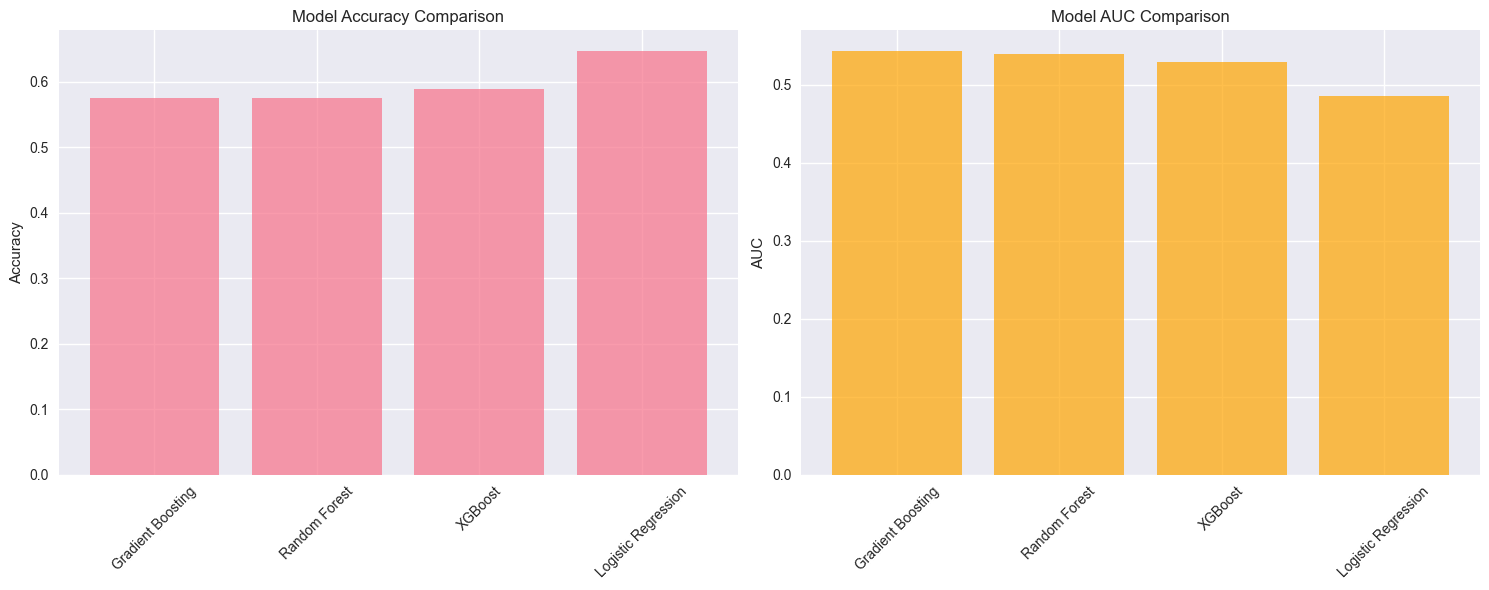

In [53]:
# Compare model performance
print("Model Performance Comparison (Validation Set):")
print("=" * 60)

results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[name]['accuracy'] for name in model_results.keys()],
    'AUC': [model_results[name]['auc'] for name in model_results.keys()]
})

results_df = results_df.sort_values('AUC', ascending=False)
print(results_df.to_string(index=False))

# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
axes[0].bar(results_df['Model'], results_df['Accuracy'], alpha=0.7)
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)

# AUC comparison
axes[1].bar(results_df['Model'], results_df['AUC'], alpha=0.7, color='orange')
axes[1].set_title('Model AUC Comparison')
axes[1].set_ylabel('AUC')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

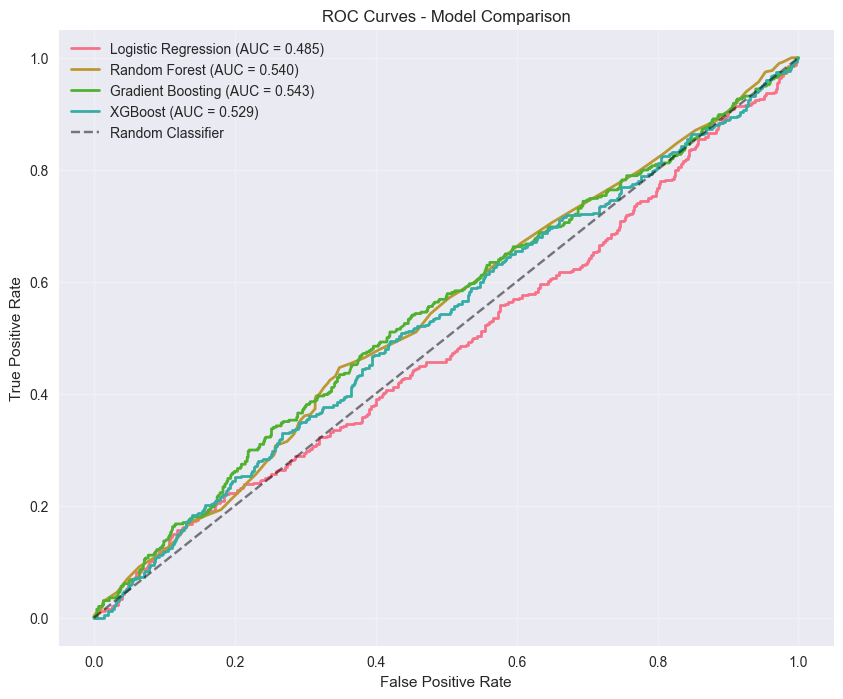

In [54]:
# ROC curves for all models
plt.figure(figsize=(10, 8))

for name in model_results.keys():
    fpr, tpr, _ = roc_curve(y_val, model_results[name]['probabilities'])
    auc = model_results[name]['auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Best Model: Gradient Boosting

📋 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       726
           1       0.40      0.40      0.40       394

    accuracy                           0.57      1120
   macro avg       0.53      0.53      0.53      1120
weighted avg       0.58      0.57      0.58      1120



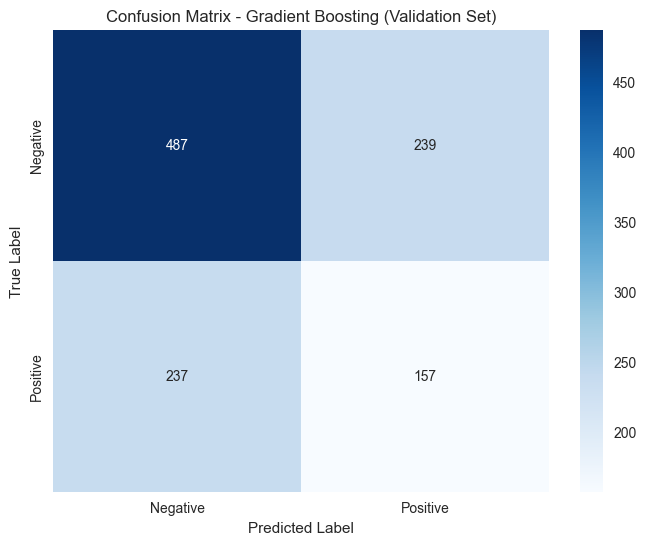

In [55]:
# Detailed classification report for best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print("=" * 25)

# Validation set report
y_val_pred = model_results[best_model_name]['predictions']
print("\n📋 Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name} (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 7. Feature Importance Analysis

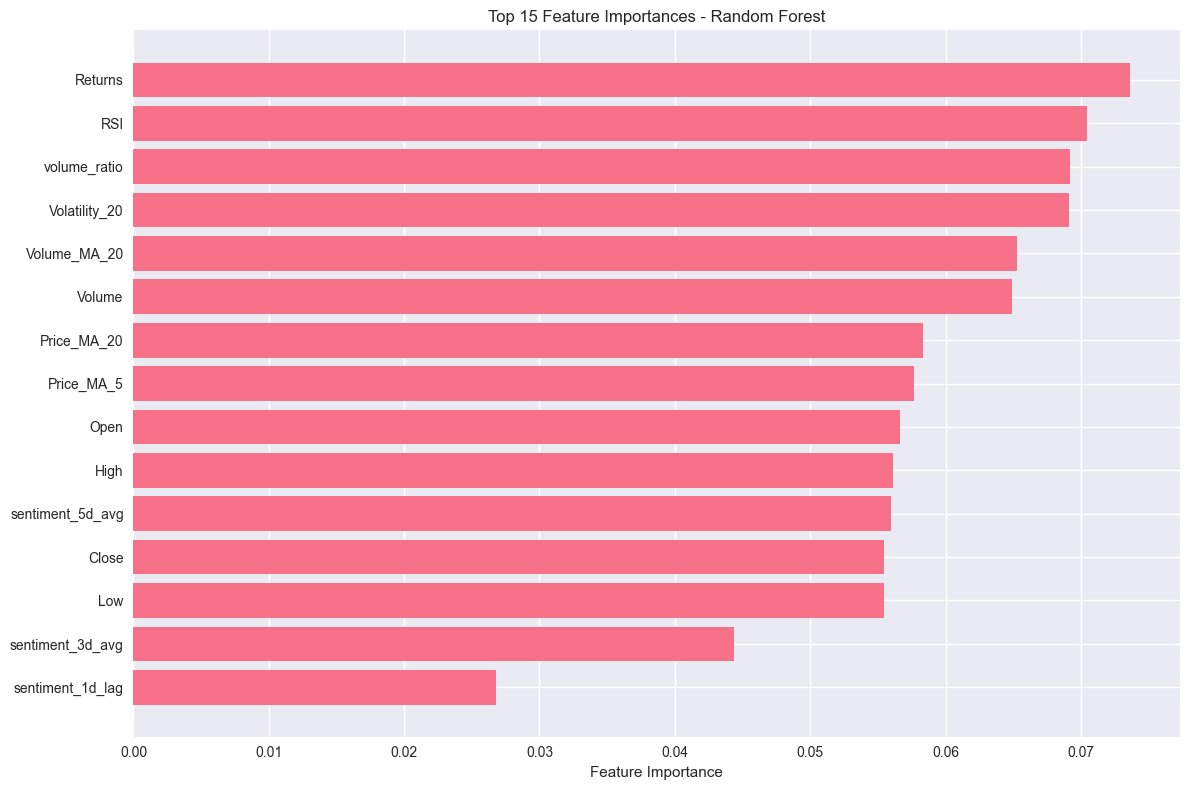


Top 10 Most Important Features (Random Forest):
      feature  importance
      Returns    0.073643
          RSI    0.070467
 volume_ratio    0.069233
Volatility_20    0.069138
 Volume_MA_20    0.065299
       Volume    0.064886
  Price_MA_20    0.058349
   Price_MA_5    0.057705
         Open    0.056652
         High    0.056104


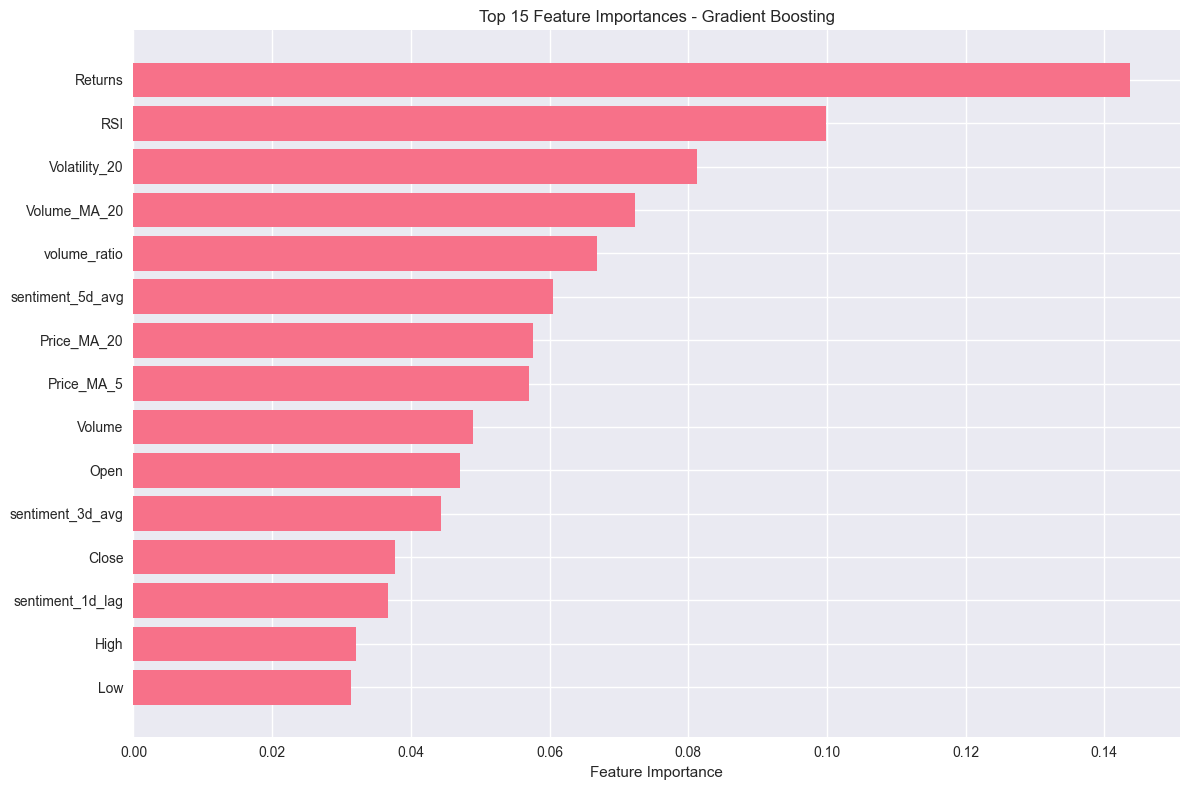


Top 10 Most Important Features (Gradient Boosting):
         feature  importance
         Returns    0.143732
             RSI    0.099827
   Volatility_20    0.081203
    Volume_MA_20    0.072372
    volume_ratio    0.066879
sentiment_5d_avg    0.060570
     Price_MA_20    0.057610
      Price_MA_5    0.057026
          Volume    0.048910
            Open    0.047026


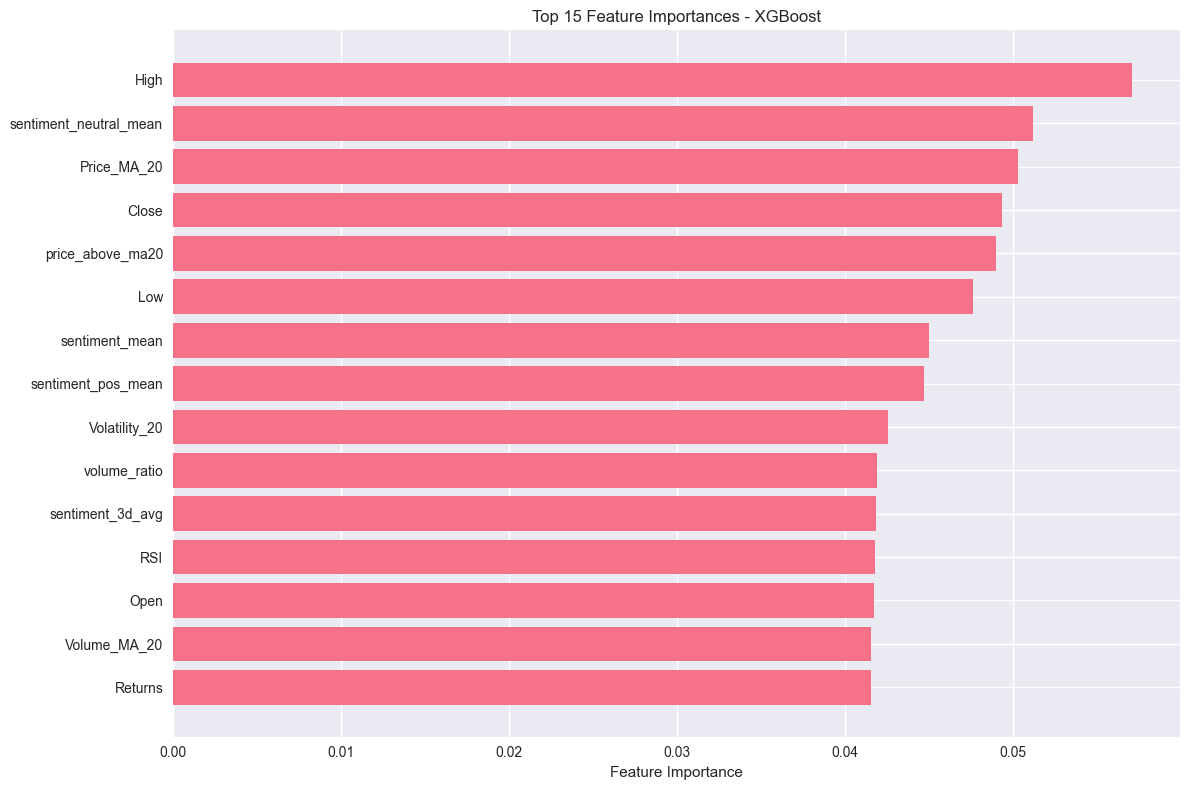


Top 10 Most Important Features (XGBoost):
               feature  importance
                  High    0.057063
sentiment_neutral_mean    0.051186
           Price_MA_20    0.050264
                 Close    0.049329
      price_above_ma20    0.048950
                   Low    0.047622
        sentiment_mean    0.044962
    sentiment_pos_mean    0.044671
         Volatility_20    0.042537
          volume_ratio    0.041905


In [56]:
# Feature importance for tree-based models
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

for model_name in tree_models:
    if model_name in trained_models:
        model = trained_models[model_name]
        
        if hasattr(model, 'feature_importances_'):
            # Get feature importance
            importances = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Plot top 15 features
            plt.figure(figsize=(12, 8))
            top_features = feature_importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'].tolist())
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
            print(f"\nTop 10 Most Important Features ({model_name}):")
            print(feature_importance_df.head(10).to_string(index=False))

## 8. Test Set Evaluation

Final Evaluation on Test Set - Gradient Boosting
Test Accuracy: 0.5633
Test AUC: 0.4930

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       698
           1       0.41      0.34      0.37       424

    accuracy                           0.56      1122
   macro avg       0.52      0.52      0.52      1122
weighted avg       0.55      0.56      0.55      1122



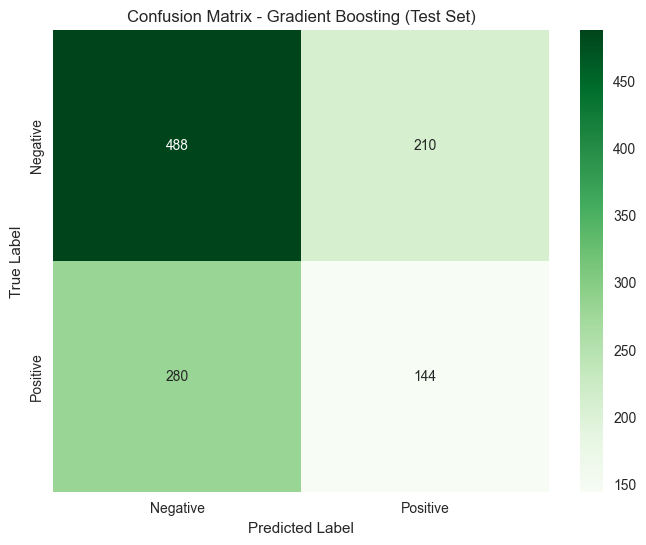

In [57]:
# Evaluate best model on test set
print(f"Final Evaluation on Test Set - {best_model_name}")
print("=" * 25)

# Make predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate test metrics
test_accuracy = (y_test_pred == y_test).mean()
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 9. Model Persistence and Trading Strategy

In [58]:
# Save the best model and scaler
print("Saving models and preprocessing objects...")

# Save best model
best_model_path = f'../models/{best_model_name.lower().replace(" ", "_")}_model.pkl'
joblib.dump(best_model, best_model_path)
print(f"Best model saved: {best_model_path}")

# Save scaler
scaler_path = '../models/feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Save feature names
feature_names_path = '../models/feature_names.pkl'
joblib.dump(feature_cols, feature_names_path)
print(f"Feature names saved: {feature_names_path}")

# Save all models for comparison
all_models_path = '../models/all_models.pkl'
joblib.dump(trained_models, all_models_path)
print(f"All models saved: {all_models_path}")

Saving models and preprocessing objects...
Best model saved: ../models/gradient_boosting_model.pkl
Scaler saved: ../models/feature_scaler.pkl
Feature names saved: ../models/feature_names.pkl
All models saved: ../models/all_models.pkl


In [59]:
# Create trading strategy summary
strategy_summary = {
    'best_model': best_model_name,
    'validation_accuracy': results_df.iloc[0]['Accuracy'],
    'validation_auc': results_df.iloc[0]['AUC'],
    'test_accuracy': test_accuracy,
    'test_auc': test_auc,
    'feature_count': len(feature_cols),
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'date_range': f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}",
    'stocks_covered': df['ticker'].nunique(),
    'model_training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("Trading Strategy Summary:")
print("=" * 25)
for key, value in strategy_summary.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

# Save strategy summary
summary_path = '../outputs/model_performance_summary.json'
import json
with open(summary_path, 'w') as f:
    json.dump(strategy_summary, f, indent=2)
print(f"\nStrategy summary saved: {summary_path}")

Trading Strategy Summary:
Best Model: Gradient Boosting
Validation Accuracy: 0.575
Validation Auc: 0.5427818797108137
Test Accuracy: 0.5632798573975044
Test Auc: 0.49300562253338387
Feature Count: 30
Training Samples: 5230
Validation Samples: 1120
Test Samples: 1122
Date Range: 2022-01-05 to 2024-12-27
Stocks Covered: 10
Model Training Date: 2025-07-12 11:12:32

Strategy summary saved: ../outputs/model_performance_summary.json


## 10. Trading Signal Analysis

In [60]:
# Analyze trading signals
print("Trading Signal Analysis")
print("=" * 25)

# Get predictions for all data
all_predictions = best_model.predict(X_scaled)
all_probabilities = best_model.predict_proba(X_scaled)[:, 1]

# Add predictions to dataframe
df_with_predictions = df.copy()
df_with_predictions['predicted_signal'] = all_predictions
df_with_predictions['prediction_probability'] = all_probabilities

# Signal distribution
print(f"Signal Distribution:")
print(f"Buy signals (1): {all_predictions.sum()} ({all_predictions.mean()*100:.1f}%)")
print(f"Sell signals (0): {(all_predictions == 0).sum()} ({(all_predictions == 0).mean()*100:.1f}%)")

# Analyze signal quality by probability threshold
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
print(f"\nSignal Quality by Probability Threshold:")
print("Threshold | Signals | Accuracy | Precision")
print("-" * 25)

for threshold in thresholds:
    high_conf_mask = all_probabilities >= threshold
    if high_conf_mask.sum() > 0:
        high_conf_preds = all_predictions[high_conf_mask]
        high_conf_actuals = y[high_conf_mask]
        
        accuracy = (high_conf_preds == high_conf_actuals).mean()
        precision = (high_conf_preds & high_conf_actuals).sum() / high_conf_preds.sum() if high_conf_preds.sum() > 0 else 0
        
        print(f"{threshold:9.1f} | {high_conf_mask.sum():7d} | {accuracy:8.3f} | {precision:9.3f}")

# Save predictions for backtesting
predictions_path = '../outputs/model_predictions.csv'
df_with_predictions.to_csv(predictions_path, index=False)
print(f"\n✅redictions saved: {predictions_path}")

Trading Signal Analysis
Signal Distribution:
Buy signals (1): 849 (11.4%)
Sell signals (0): 6623 (88.6%)

Signal Quality by Probability Threshold:
Threshold | Signals | Accuracy | Precision
-------------------------
      0.5 |     849 |    0.470 |     0.470
      0.6 |     701 |    0.437 |     0.437
      0.7 |     599 |    0.414 |     0.414
      0.8 |     537 |    0.400 |     0.400
      0.9 |     285 |    0.379 |     0.379

✅redictions saved: ../outputs/model_predictions.csv
